In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

inspector = inspect(engine)

# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found

columns = inspector.get_columns('measurement')
print('\nmeasurement:')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
print('\nstation:')
for c in columns:
    print(c['name'], c["type"])


measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Save references to each table

Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_data = calc_temps('2017-08-01','2017-08-07')
print(temp_data)

[(72.0, 79.25, 83.0)]


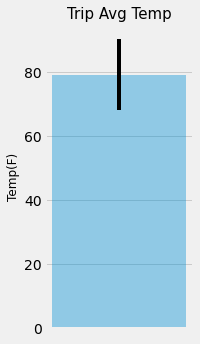

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = temp_data[0][1]
err = [temp_data[0][2] - temp_data[0][0]]

fig, ax = plt.subplots(figsize=(3,5))
ax.bar(1,height=[avg_temp], yerr=err, align='center', alpha=0.4, ecolor='black')

ax.set_ylabel('Temp(F)',fontsize=12)
ax.set_title('Trip Avg Temp', fontsize=15)

ax.set_xticklabels([])
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.tight_layout()

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

measurement_df = pd.DataFrame(session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all())

station_df = pd.DataFrame(session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation).all())

complete_data_df = pd.merge(measurement_df, station_df, on='station', how='inner')
complete_data_df = complete_data_df.drop(['id_x','id_y'], axis=1)

total_rainfall_per_station = complete_data_df[(complete_data_df['date'] >= '2017-08-01') & ( complete_data_df['date'] <= '2017-08-07')]

total_rainfall_per_station = total_rainfall_per_station[['station','date','prcp','latitude','longitude','elevation']].groupby('station')['prcp'].sum()
total_rainfall_per_station

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall_per_station.sort_values(ascending=False)

rainfall_df = pd.merge(total_rainfall_per_station, station_df,on='station', how='inner')
rainfall_df.sort_values(['prcp'],ascending=False)

,station,prcp,id,name,latitude,longitude,elevation
1,USC00516128,0.36,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
0,USC00514830,0.22,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [16]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session